# **Analysis Hotel Booking Demand**

In [195]:
from custom_functions import *
import xgboost

In [196]:
# conda install -c conda-forge xgboost
# pip3 install xgboost

In [209]:
df_original = pd.read_csv('hotel_bookings.csv')

# Exploratory Data Analysis I (EDA I)

In [210]:
value_counts_csv(df_original)
count_nulls(df_original)
hist_boxplot(df_original)

In [211]:
# Number of rows and columns
df_original.shape

(119390, 32)

In [212]:
def min_max(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

## - First Remarks and ideas for each column

- <span style='color:Orange'> **hotel** </span>: 2 classes, 66% City Hotel, 33% Resort Hotel
- <span style='color:Orange'> **is_canceled** </span> (target_label): 2 values, 0 (62%) or 1 (38%). It is quite unbalanced
- <span style='color:Orange'> **lead_time** </span>: many values, grouping by new categories? Skewed distributions towards the 0 value
- <span style='color:Orange'> **arrival_date_year** </span>: 3 years, 2015, 2016 and 2017
- <span style='color:Orange'> **arrival_date_month** </span>: many arrivals in June and July, it makes sense
- <span style='color:Orange'> **arrival_date_week_number** </span>: probably we can combine it with arrival_date_month. It has a quite normal distribution
- <span style='color:Orange'> **arrival_date_day_of_month** </span>: considering we have week_number and month_number we can eliminate this label
- <span style='color:Orange'> **stays_in_weekend_nights** </span>: skewed distribution towards 0, we could eliminate some big values
- <span style='color:Orange'> **stays_in_week_nights** </span>: same thought of previous label
- <span style='color:Orange'> **adults** </span>: 2 is 75% and 1 is 19%, there are some values with 0
- <span style='color:Orange'> **children** </span>: 93% has 0 children, we can think of eliminate this label or consider to create only a binary class, 4 <span style='color:Yellow'> **null** </span> values
- <span style='color:Orange'> **babies** </span>: 99% has 0 babies, same thought of children
- <span style='color:Orange'> **meal** </span>: 3 relevant classes, BB 77%, HB 12% and SC 8%
- <span style='color:Orange'> **country** </span>: 6 relevant classes, PRT 41%, GBR 10%, FRA 9%, ESP 7%, DEU 6%, ITA 3%, 0.4% of <span style='color:Yellow'> **null** </span> values
- <span style='color:Orange'> **market_segment** </span>: 5 relevant classes, Online TA 47%, Offline TA/TO 20%, Groups 17%, Direct 10% and Corporate 4.4%
- <span style='color:Orange'> **distribution_channel** </span>: 3 relevant classes TA/TO 82%, Direct 12% and Corporate 5%
- <span style='color:Orange'> **is_repeated_guest** </span>: the clients are quite new, 0 is 97% and 1 is 3%
- <span style='color:Orange'> **previous_cancellations** </span>: two relevant classes, 0 is about 95% and 1 is about 5%. We could transform this into a binary label
- <span style='color:Orange'> **previous_bookings_not_canceled** </span>: it is not relevant since we have previous cancellations.
- <span style='color:Orange'> **reserved_room_type** </span>: 4 relevant classes, A is 72%, D is 16%, E is 5%, F is 2.4 %
- <span style='color:Orange'> **assigned_room_type** </span>: 3 relevant classes, A is 62%, B 21% and E 6%. It could be interesting to know when the customer knows the **assigned_room_type**. If they knew this online some time before, it could be a reason for cancellation
- <span style='color:Orange'> **booking_changes** </span>: distribution is skewed towards 0, 3 relevant classes, 0 is 85%, 1 is 10% and 2 is 3%. More changes imply a high probable cancellation?
- <span style='color:Orange'> **deposit_type** </span>: only 3 classes, No deposit 87%, Non Refund 12% and Refundable 1%. We could Merge Refundable with No deposit? Non refund implies no cancellation?
- <span style='color:Orange'> **agent** </span>: too many values, it seems to be without important information, 13% <span style='color:Yellow'> **nulls** </span>. We can cancel this label
- <span style='color:Orange'> **company** </span>: 94% of rows are <span style='color:Yellow'> **null** </span>
- <span style='color:Orange'> **days_in_waiting_list** </span>: there are many values but 97% of rows is 0. Binary label?
- <span style='color:Orange'> **customer_type** </span>: only 4 classes, Transient is 75%, Transient-Party 21%, Contract is about 3.5% and Group is about 0.5%
- <span style='color:Orange'> **adr** </span>: there are some annoying outliers, we need to group the values somehow
- <span style='color:Orange'> **required_car_parking_spaces** </span>: only two relevant classes, 0 is about 94% and 1 is about 6%. Trasnform it in a binary label
- <span style='color:Orange'> **total_of_special_requests** </span>: only 3 relevant classes, 0 is 59%, 1 is 28% and 2 is 10%. Maybe we could group the information
- <span style='color:Orange'> **reservation_status** </span>: this is a posteriori information, we should eliminate it
- <span style='color:Orange'> **reservation_status_date** </span>: non-important information, eliminate this

# Feature Engineering I

### - Grouping, Treating outliers and null values

In [213]:
df = df_original.copy()

# lead_time column
df['lead_time'] = np.where(df['lead_time']>365, 365, df['lead_time'])

# arrival_date_month
df.drop('arrival_date_month', axis = 1, inplace = True)

# arrival_date_week_number
# Grouping considering first half of the month and second half
df['arrival_date_week_number'] = (df['arrival_date_week_number']-1) // 2

# arrival_date_day_of_month
df.drop('arrival_date_day_of_month', axis = 1, inplace = True)

# stays_in_weekend_nights
df['stays_in_weekend_nights'] = np.where(df['stays_in_weekend_nights']>2, 3, df['stays_in_weekend_nights'])

# stays_in_week_nights
df['stays_in_week_nights'] = np.where(df['stays_in_week_nights']>5, 6, df['stays_in_week_nights'])

# adults
df['adults'] = np.where(df['adults']>3, 3, df['adults'])
df['adults'].replace(0, df['adults'].median(), inplace = True)

# children
df['children'] = np.where(df['children']>0, 1, df['children'])
df['children'].replace(np.nan, 0, inplace = True)

# babies
df.drop('babies', axis = 1, inplace = True)

# meal
# We merge Undefined with SC (no service)
# and full breakfast with half breakfast
df['meal'].replace({'Undefined': 'SC', 'FB':'HB'}, inplace = True)

# country
countries = pd.read_csv('value_counts_csv/country.csv')
top_country = list(countries['country'].head(6))
df['country'] = np.where(df['country'].isin(top_country), df['country'], 'Others')

# market_segment and distribution_channel
# Further EDA for studying the relation between 
# market_segment and distribution_channel, they seem similar
df.groupby(['market_segment', 'distribution_channel']).size().unstack()

distribution_channel,Corporate,Direct,GDS,TA/TO,Undefined
market_segment,,,,,
Aviation,227.0,NaN,NaN,10.0,NaN
Complementary,89.0,576.0,NaN,78.0,NaN
Corporate,4788.0,172.0,NaN,335.0,NaN
Direct,90.0,12276.0,1.0,237.0,2.0
Groups,1228.0,1472.0,NaN,17111.0,NaN
Offline TA/TO,212.0,16.0,45.0,23946.0,NaN
Online TA,43.0,133.0,147.0,56153.0,1.0
Undefined,NaN,NaN,NaN,NaN,2.0


- <span style='color:Orange'> **Market segment** </span> seems to be a specialization of <span style='color:Orange'> **distribution channel** </span>. We decide to keep the former and drop the latter

In [214]:
df.drop('distribution_channel', axis = 1, inplace = True)

market_segments = pd.read_csv('value_counts_csv/market_segment.csv')
top_segments = list(market_segments['market_segment'].head(4))
df['market_segment'] = np.where(df['market_segment'].isin(top_segments), df['market_segment'], 'Others')

# previous_cancellations
df['previous_cancellations'] = np.where(df['previous_cancellations']>1, 1, 0)

# previous_bookings_not_canceled
df.drop('previous_bookings_not_canceled', axis = 1, inplace = True)

# reserved_room_type
room_types = pd.read_csv('value_counts_csv/reserved_room_type.csv')
top_room = list(room_types['reserved_room_type'].head(4))
df['reserved_room_type'] = np.where(df['reserved_room_type'].isin(top_room), df['reserved_room_type'], 'Others')

- We interpret the assigned_room_type label as assigned a posteriori. Therefore we decide to drop it

In [215]:
# assigned_room_type
df.drop('assigned_room_type', axis = 1, inplace = True)

# booking_changes
df['booking_changes'] = np.where(df['booking_changes']>2, 2, df['booking_changes'])

# deposit_type
df['deposit_type'].replace('Refundable', 'No Deposit', inplace = True)

# agent
df.drop('agent', axis = 1, inplace = True)

# company
df.drop('company', axis = 1, inplace = True)

# days_in_waiting_list
df['days_in_waiting_list'] = np.where(df['days_in_waiting_list']>0, 1, 0)

- We are confused about the interpretation of the <font color='orange'>**adr**</font> label and we decide not to consider it. We are not sure if it includes some a posteriori information. We can come back to it in further phase if some new interpreation arises.

In [216]:
# required_car_parking_spaces
df['required_car_parking_spaces'] = np.where(df['required_car_parking_spaces']>0, 1, 0)

# total_of_special_requests
df['total_of_special_requests'] = np.where(df['total_of_special_requests']>1, 2, df['total_of_special_requests'])

# reservation_status and reservation_status_date
df.drop(['reservation_status', 'reservation_status_date'], axis = 1, inplace = True)

In [217]:
# We check how many columns we have
# after the droppings
df.shape

(119390, 22)

### - Handling Categorical features

- We are going to treat the 7 categorical features that we have: <span style='color:Orange'> **hotel** </span>, <span style='color:Orange'> **meal** </span>, <span style='color:Orange'> **country** </span>, <span style='color:Orange'> **market_segment** </span>, <span style='color:Orange'> **reserved_room_type** </span>, <span style='color:Orange'> **deposit_type** </span> and <span style='color:Orange'> **customer_type** </span> . For the moment we consider them as **ordinal categorical features**

In [218]:
def cat_dummies(df):
    assert isinstance(df, pd.DataFrame)
    
    cat_cols = df.columns[df.dtypes==object].tolist()
    df = pd.get_dummies(df, prefix = cat_cols, columns = cat_cols)
    return(df)


In [219]:
df = cat_dummies(df)
#df = pd.get_dummies(df)

In [ ]:
# We check how many columns we have
# after get_dummies
df.shape

### - Feature Scaling

In [ ]:
# min-max transformation
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()
df[df.columns] = min_max.fit_transform(df[df.columns])

# EDA II

### - Correlations and Associations Study

In [69]:
from pandas.api.types import is_numeric_dtype, is_string_dtype
from scipy.stats import chi2_contingency

In [70]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [71]:
#anova_model = ols('lead_time ~ C(hotel)', df).fit()
#anova_results = anova_lm(anova_model)
#print(anova_results)

In [72]:
#name_col_2 = 'lead_time'
#name_col_1 = 'hotel'

In [73]:
#anova_model = ols(name_col_2+str(' ~ C(')+str(name_col_1)+str(')'), df).fit()
#anova_results = anova_lm(anova_model)
#print(anova_results)

In [135]:
import numpy as np

In [141]:
def correlation_matrix(df, method_numeric='pearson'):
    
    """
    Comment here
    
    """
    l = df.shape[1]
    matrix = np.zeros(shape=(l,l))
    matrix_mask = np.zeros(shape=(l,l))

    for j in range(l):
        col_1 = df.iloc[:,j]
        name_col_1 = df.columns[j]
        
        for i in range(j,l):
            col_2 = df.iloc[:,i]
            name_col_2 = df.columns[i]
            
            if is_numeric_dtype(col_1) and is_numeric_dtype(col_2):
                correlation = col_1.corr(col_2)
                matrix[j,i] = matrix[i,j] = correlation
                matrix_mask[j,i] = matrix_mask[i,j] = 1
                
            elif is_string_dtype(col_1) and is_string_dtype(col_2):
                frequency_table = pd.crosstab(col_1, col_2)
                
                chi2 = chi2_contingency(frequency_table)[0]
                
                total_frequencies = df.shape[0]
                phi2 = chi2/total_frequencies
                r, k = frequency_table.shape
                cramer = np.sqrt(phi2/min((r-1),(k-1)))
                matrix[i,j] = matrix[j,i] = cramer
                matrix_mask[j,i] = matrix_mask[i,j] = 2
             
            elif is_string_dtype(col_1) and is_numeric_dtype(col_2):
                anova_model = ols(name_col_2 + str(' ~ C(') + name_col_1 + str(')'), df).fit()
                anova_results = anova_lm(anova_model)
                eta2 = anova_results['sum_sq'][0]/(anova_results['sum_sq'][0]+anova_results['sum_sq'][1])
                matrix[i,j] = matrix[j,i] = eta2
                matrix_mask[j,i] = matrix_mask[i,j] = 3
            
            elif is_numeric_dtype(col_1) and is_string_dtype(col_2):
                anova_model = ols(name_col_1 + str(' ~ C(') + name_col_2 + str(')'), df).fit()
                anova_results = anova_lm(anova_model)
                eta2 = anova_results['sum_sq'][0]/(anova_results['sum_sq'][0]+anova_results['sum_sq'][1])
                matrix[i,j] = matrix[j,i] = eta2
                matrix_mask[j,i] = matrix_mask[i,j] = 3
            
            else: 
                matrix[i,j] = matrix[j,i] = np.nan
                
                
    return((matrix, matrix_mask))
            
        
    

In [144]:
matrices = correlation_matrix(df)

In [145]:
matrix_corr = matrices[0]

In [146]:
matrix_mask = matrices[1]

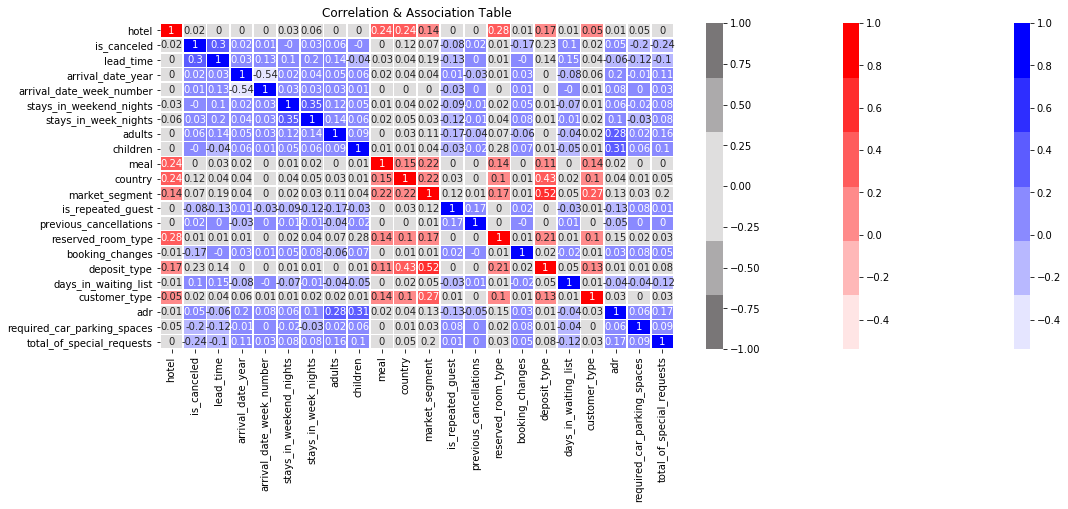

In [167]:
matrix_corr = np.around(matrix_corr, 2)

pd_matrix = pd.DataFrame(matrix_corr)
pd_matrix.columns = df.columns
pd_matrix.set_index(df.columns, inplace=True)

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

mask_num = np.where(matrix_mask == 1, False, True)
mask_cat = np.where(matrix_mask == 2, False, True)
mask_mixed = np.where(matrix_mask == 3, False, True)

cm_blue = sns.light_palette("blue", as_cmap=False)
cm_red = sns.light_palette("red", as_cmap=False)
cm_grey = sns.diverging_palette(h_neg=1,h_pos=1, s=1, as_cmap=False)

plt.figure(figsize = (18,6))
#legend missing
plt.title('Correlation & Association Table')
sns.heatmap(pd_matrix, annot=True, mask=mask_num, cmap=cm_blue, linewidths =.7)
sns.heatmap(pd_matrix, annot=True, mask=mask_cat, cmap=cm_red, linewidths =.7)
sns.heatmap(pd_matrix, annot=True, mask=mask_mixed, cmap=cm_grey, vmax=1, vmin=-1, linewidths =.7)


# Feature Selection And Dimensionality Reduction

In [168]:
df.var()

is_canceled                        0.233210
lead_time                      10122.428771
arrival_date_year                  0.500522
arrival_date_week_number          46.361304
stays_in_weekend_nights            0.820652
stays_in_week_nights               2.337720
adults                             0.225799
children                           0.066773
is_repeated_guest                  0.030894
previous_cancellations             0.003614
booking_changes                    0.247884
days_in_waiting_list               0.030015
adr                             2553.866100
required_car_parking_spaces        0.058258
total_of_special_requests          0.513540
dtype: float64

In [ ]:
from sklearn.feature_selection import VarianceThreshold
X = [[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 1, 1], [0, 1, 0], [0, 1, 1]]
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

In [220]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier()
xgb_model = xgb.XGBClassifier()


y = df['is_canceled']
X = df.drop('is_canceled', axis = 1)

# step tells you how many feature to remove at every step
# StratifiedKFold preserves the percentage of every class
#n_jobs is for parallel processing, -1 means all
rfecv = RFECV(estimator=rfc_model, step=1, cv=StratifiedKFold(2), 
              scoring='accuracy', n_jobs = -1, verbose = 1)

rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 fe

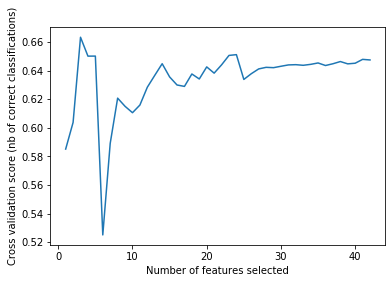

In [221]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Optimal number of features : 3
Best features : Index(['lead_time', 'adr', 'deposit_type_Non Refund'], dtype='object')
Original features : Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'is_repeated_guest', 'previous_cancellations', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_City Hotel', 'hotel_Resort Hotel',
       'meal_BB', 'meal_HB', 'meal_SC', 'country_DEU', 'country_ESP',
       'country_FRA', 'country_GBR', 'country_ITA', 'country_Others',
       'country_PRT', 'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'market_segment_Others', 'reserved_room_type_A', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F',
       'reserved_room_type_Others', 'deposit_type_No Deposit',
       'deposit_

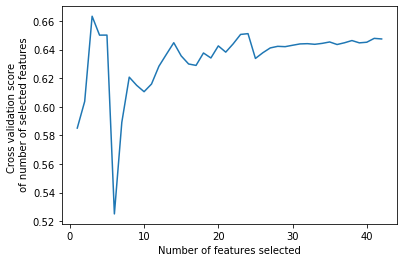

In [226]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
print('Original features :', X.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [228]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier()
xgb_model = xgb.XGBClassifier()


y = df['is_canceled']
X = df.drop('is_canceled', axis = 1)

# step tells you how many feature to remove at every step
# StratifiedKFold preserves the percentage of every class
#n_jobs is for parallel processing, -1 means all
rfecv = RFECV(estimator=xgb_model, step=1, cv=StratifiedKFold(2), 
              scoring='accuracy', n_jobs = -1, verbose = 1)

rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 fe

Optimal number of features : 1
Best features : Index(['deposit_type_No Deposit'], dtype='object')
Original features : Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'is_repeated_guest', 'previous_cancellations', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_City Hotel', 'hotel_Resort Hotel',
       'meal_BB', 'meal_HB', 'meal_SC', 'country_DEU', 'country_ESP',
       'country_FRA', 'country_GBR', 'country_ITA', 'country_Others',
       'country_PRT', 'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline TA/TO', 'market_segment_Online TA',
       'market_segment_Others', 'reserved_room_type_A', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F',
       'reserved_room_type_Others', 'deposit_type_No Deposit',
       'deposit_type_Non Refund', 'c

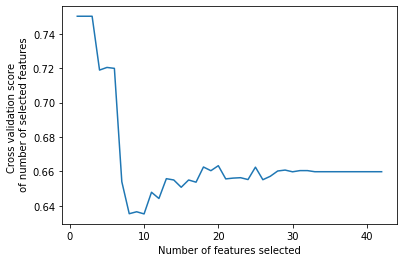

In [229]:
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])
print('Original features :', X.columns)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score \n of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
#def correlation_ratio(categories, measurements):
        #fcat, _ = pd.factorize(categories)
        #cat_num = np.max(fcat)+1
        #y_avg_array = np.zeros(cat_num)
        #n_array = np.zeros(cat_num)
        
        #for i in range(0,cat_num):
            #cat_measures = measurements[np.argwhere(fcat == i).flatten()]
            #n_array[i] = len(cat_measures)
            #y_avg_array[i] = np.average(cat_measures)
            
        #y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
        #numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
        #denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
        
        #if numerator == 0:
            #eta = 0.0
        #else:
            #eta = numerator/denominator
        #return eta

In [ ]:
#def cramers_v(x, y):
    #confusion_matrix = pd.crosstab(x,y)
    #chi2 = ss.chi2_contingency(confusion_matrix)[0]
    #n = confusion_matrix.sum().sum()
    #phi2 = chi2/n
    #r,k = confusion_matrix.shape
    #phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    #rcorr = r-((r-1)**2)/(n-1)
    #kcorr = k-((k-1)**2)/(n-1)
    #return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
correlation_matrix(df)

In [ ]:
help(correlation_matrix)

# OLD CODE

In [ ]:
python setup.py install--user

In [ ]:
df_model = df.copy()
df_model = df_model.select_dtypes(exclude=['object'])
df_model = pd.get_dummies(df_model)

In [ ]:
df_model.shape
#df.shape

In [ ]:
X = df_model.drop('is_canceled', axis = 1)
y = df_model['is_canceled']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
y.value_counts()

In [ ]:
#Import libraries:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

In [ ]:
D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(X_test, label=Y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps)

preds = model.predict(D_test)
print(preds)

best_preds = np.asarray([np.argmax(line) for line in preds])
print(best_preds)

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

In [ ]:
xgb_clf = xgb.XGBClassifier()

parameters = {
     "eta"    : [0.20, 0.30] ,
     "max_depth"        : [ 3, 6],
     "gamma"            : [ 0.1, 0.2]
     }

grid = GridSearchCV(xgb_clf,
                    parameters,
                    scoring="neg_log_loss",
                    cv=3)

model = grid.fit(X_train, Y_train)
#predictions = model.predict(X_test)

#model.dump_model('dump.raw.txt')

In [ ]:
preds = model.predict(X_test)
print(preds)

In [ ]:
model.best_estimator_

In [ ]:
model.best_params_
model.best_estimator_
cvres = model.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

In [ ]:
xgb_model = xgb.XGBClassifier()

#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [5], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}


clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(train['QuoteConversion_Flag'], n_folds=5, shuffle=True), 
                   scoring='roc_auc',
                   verbose=2, refit=True)

clf.fit(train[features], train["QuoteConversion_Flag"])

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(test[features])[:,1]

sample = pd.read_csv('../input/sample_submission.csv')
sample.QuoteConversion_Flag = test_probs
sample.to_csv("xgboost_best_parameter_submission.csv", index=False)

In [ ]:
def classifier_gridCV(X_train, y_train, clf, 
                      X_test = None, y_test = None, cv = 3, scoring = 'accuracy', params = {}, model_name = "model"):
    
    grid = GridSearchCV(clf, params, cv = cv, scoring = scoring, refit = True)
    
    model = grid.fit(X_train, y_train)
    print("The best parameters of grid are: ", model.best_params_, 
          "\nThe best estimator is: ", model.best_estimator_)
    
    if not os.path.exists('Models/CV_results'):
        os.makedirs('Models/CV_results')
    
    cvres = model.cv_results_
    
    if params != {}:    
        dataframe = pd.DataFrame(cvres["params"])
        dataframe.insert(0, "mean_test_score", cvres["mean_test_score"])
                        
    else: 
        dataframe = pd.DataFrame({"mean_test_score":cvres["mean_test_score"]})
            
    dataframe.to_csv("./Models/CV_results/CV_results_"+model_name+".csv", index = False) 
    
    if X_test is not None:
        results = model.predict(X_test)
    
        if y_test is not None:
            print("Precision = {}".format(precision_score(y_test, results, average='macro')))
            print("Recall = {}".format(recall_score(y_test, results, average='macro')))
            print("Accuracy = {}".format(accuracy_score(y_test, results)))
            
    return(model)
    

In [ ]:
classifier_gridCV(X_train, Y_train, xgb.XGBClassifier(), X_test, Y_test, 
                  model_name = "xg_boost_2")